In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql.types import *
from pyspark.sql import Row
from datetime import datetime
from pyspark.sql import SparkSession

conf = SparkConf().setAppName("RandomForest").setMaster("local[4]")
sc = SparkContext(conf=conf)

spark = SparkSession(sc)
print "Spark context initiated.."

Spark context initiated..


In [2]:
import pyspark.mllib
import pyspark.mllib.regression
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql.functions import *
from pyspark.ml.classification import RandomForestClassifier
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.util import MLUtils


import os
cwd = os.getcwd()
os.chdir(cwd)
cwd = os.getcwd()

print "Executing in Direectory : " + cwd

Executing in Direectory : /Users/ashokkuppuraj/Downloads/project/code


In [3]:
data=sc.textFile("data/Bitcoin_USD_History.csv")
rdd = data.map(lambda line: line.split(","))
header = rdd.first()
rdd = rdd.filter(lambda line:line != header)
rdd.take(10)
base_df = rdd.map(lambda line: Row(aaclose=line[4],waitage=line[7],open=line[1],high=line[2],low=line[3],btc_vol=line[5],cur_vol=line[6],weekday=datetime.strptime(line[0],"%Y-%m-%d").date().weekday(),dt=line[0])).toDF()

print "Base File 1/3 loaded"


Base File 1/3 loaded


In [4]:
google_data=sc.textFile('data/Google-Intererst-Bitcoin.csv')
google_rdd = google_data.map(lambda line: line.split(","))
header_g = google_rdd.first()
google_rdd = google_rdd.filter(lambda line:line != header_g)
google_rdd.take(10)
google_df=google_rdd.map(lambda line: Row(dt_sp=line[0],cnt=float(line[1]))).toDF()


print "Base File 2/3 loaded"

Base File 2/3 loaded


In [5]:
data1=sc.textFile('data/export-ETHTx.csv')
data2=sc.textFile('data/export-EtherPrice.csv')
rdd1 = data1.map(lambda line: line.split(","))
rdd2 = data2.map(lambda line: line.split(","))
header1 = rdd1.first()
header2 = rdd2.first()
rdd1 = rdd1.filter(lambda line:line != header1)
rdd2 = rdd2.filter(lambda line:line != header2)
rdd1.take(10)


print "Base File 3/3 loaded"

Base File 3/3 loaded


In [6]:
ETH_TXN_df = rdd1.map(lambda line: Row(dt=line[0],utime=line[1],txns=float(line[2]))).toDF()
ETH_PRICE_df = rdd2.map(lambda line: Row(dt=line[0],utime=line[1],price=float(line[2]))).toDF()

ETH_df=ETH_TXN_df.join(ETH_PRICE_df,ETH_TXN_df.dt==ETH_PRICE_df.dt)
ETH_DF=ETH_df.rdd.map(lambda line:Row(dt_e=datetime.strptime(line[0],"%m/%d/%Y").strftime("%Y-%m-%d"),txns=line[1],price=line[4])).toDF()


In [7]:
BIT_df=base_df.join(google_df,base_df.dt==google_df.dt_sp,"left_outer")

###Join base data with Ether data 
df_all_data=BIT_df.join(ETH_DF, BIT_df.dt==ETH_DF.dt_e,"left_outer")


print "Base File merge completed with record count : " + str(df_all_data.count())


Base File merge completed with record count : 812


In [8]:
from pyspark.ml.feature import Imputer
imputer = Imputer(inputCols=["cnt", "price","txns"], outputCols=["cnt", "price","txns"])
model = imputer.fit(df_all_data)
model.surrogateDF.show()
corrected_df=model.transform(df_all_data)
corrected_df.cache()


+------------------+-----------------+-----------------+
|               cnt|            price|             txns|
+------------------+-----------------+-----------------+
|13.086206896551724|85.37229822161422|113889.7537619699|
+------------------+-----------------+-----------------+



DataFrame[aaclose: string, btc_vol: string, cur_vol: string, dt: string, high: string, low: string, open: string, waitage: string, weekday: bigint, cnt: double, dt_sp: string, dt_e: string, price: double, txns: double]

In [9]:
print "Feature correction completed - Imputer finished"

print "Correlation analysis started "



Feature correction completed - Imputer finished
Correlation analysis started 


In [10]:
print "spearman's Correlation on selected features ::"
from pyspark.mllib.stat import Statistics
aaclose_rdd=corrected_df.rdd.map(lambda l:l['aaclose']).cache()
btc_vol_rdd=corrected_df.rdd.map(lambda l:l['btc_vol']).cache()
high_rdd=corrected_df.rdd.map(lambda l:l['high']).cache()
low_rdd=corrected_df.rdd.map(lambda l:l['low']).cache()
open_rdd=corrected_df.rdd.map(lambda l:l['open']).cache()
cnt_rdd=corrected_df.rdd.map(lambda l:l['cnt']).cache()
price_rdd=corrected_df.rdd.map(lambda l:l['price']).cache()
txns_rdd=corrected_df.rdd.map(lambda l:l['txns']).cache()

print "btc_vol:" + str(Statistics.corr(aaclose_rdd,btc_vol_rdd,"spearman"))
print "high:" + str(Statistics.corr(aaclose_rdd,high_rdd,"spearman"))
print "low:" + str(Statistics.corr(aaclose_rdd,low_rdd,"spearman"))
print "open:" + str(Statistics.corr(aaclose_rdd,open_rdd,"spearman"))
print "Google_trend:" + str(Statistics.corr(aaclose_rdd,cnt_rdd,"spearman"))
print "ETH price:" + str(Statistics.corr(aaclose_rdd,price_rdd,"spearman"))
print "ETH TRANS:" + str(Statistics.corr(aaclose_rdd,txns_rdd,"spearman"))
print "btc_price<Label>:" + str(Statistics.corr(aaclose_rdd,aaclose_rdd,"spearman"))

print "Correlation analysis Completed "

spearman's Correlation on selected features ::
btc_vol:0.348540857386
high:0.998581861669
low:0.995190604708
open:0.997943642437
Google_trend:0.260343238604
ETH price:0.68683414787
ETH TRANS:0.720031468617
btc_price<Label>:1.0
Correlation analysis Completed 


In [11]:
####Correlation plots
print "Correlation plot started "

import scipy as sp
import pandas as pd
import xlrd
import matplotlib.pyplot as plt

aaclose=[float(i.aaclose) for i in corrected_df.sort(asc("dt")).collect()]
btc_vol=[float(i.btc_vol)/10 for i in corrected_df.sort(asc("dt")).collect()]
plt.plot(btc_vol, label="Bitcoin transactions", linestyle='--')
plt.plot(aaclose, label="Bitcoin USD value")
plt.ylabel("count")
plt.xlabel("Date progression")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("extract/Correlation-btc_vol.png")
plt.clf()

print "Correlation plot [-     ] "

Correlation plot started 
Correlation plot [-     ] 


In [12]:
high=[float(i.high) for i in corrected_df.sort(asc("dt")).collect()]
plt.plot(high, label="Bitcoin transactions", linestyle='--')
plt.plot(aaclose, label="Bitcoin USD value")
plt.ylabel("count")
plt.xlabel("Date progression")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("extract/Correlation-high.png")
plt.clf()

print "Correlation plot [--    ] "

Correlation plot [--    ] 


In [13]:
low=[float(i.low) for i in corrected_df.sort(asc("dt")).collect()]
plt.plot(low, label="BTC Low", linestyle='--')
plt.plot(aaclose, label="Bitcoin USD value")
plt.ylabel("count")
plt.xlabel("Date progression")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("extract/Correlation-low.png")
plt.clf()

print "Correlation plot [---   ]"

Correlation plot [---   ]


In [14]:
open=[float(i.open) for i in corrected_df.sort(asc("dt")).collect()]
plt.plot(open, label="BTC open", linestyle='--')
plt.plot(aaclose, label="Bitcoin USD value")
plt.ylabel("count")
plt.xlabel("Date progression")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("extract/Correlation-open.png")
plt.clf()

print "Correlation plot [----  ] "

Correlation plot [----  ] 


In [15]:
cnt=[float(i.cnt)*60 for i in corrected_df.sort(asc("dt")).collect()]
plt.plot(cnt, label="Google Trend", linestyle='--')
plt.plot(aaclose, label="Bitcoin USD value")
plt.ylabel("count")
plt.xlabel("Date progression")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("extract/Correlation-Googletrend.png")
plt.clf()

print "Correlation plot [----- ]"

Correlation plot [----- ]


In [16]:
price=[float(i.price)*10 for i in corrected_df.sort(asc("dt")).collect()]
plt.plot(price, label="ETH USD value", linestyle='--')
plt.plot(aaclose, label="Bitcoin USD value")
plt.ylabel("count")
plt.xlabel("Date progression")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("extract/Correlation-ETH.png")
plt.clf()

print "Correlation plot [------] "

Correlation plot [------] 


In [17]:
txns=[float(i.txns)/20 for i in corrected_df.sort(asc("dt")).collect()]
plt.plot(txns, label="ETH treansaction count", linestyle='--')
plt.plot(aaclose, label="Bitcoin USD value")
plt.ylabel("count")
plt.xlabel("Date progression")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("extract/Correlation-ETHtxns.png")
plt.clf()

In [18]:
print "All plots are exported to "+str(cwd)+'/'+'extract'+" folder"
print "Model initiated - Random Forest "


All plots are exported to /Users/ashokkuppuraj/Downloads/project/code/extract folder
Model initiated - Random Forest 


In [19]:

df=corrected_df.select([c for c in corrected_df.columns if c not in {'dt','dt_e','dt_sp','cnt','price','txns','high','low','open'}])
temp = df.rdd.map(lambda line:LabeledPoint(line[0],[line[1:]]))
temp.take(5)
(trainingData, testData) = temp.randomSplit([0.8, 0.2])


model = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo={},numTrees=8, featureSubsetStrategy="auto",impurity='variance', maxDepth=30, maxBins=32)
predictions = model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)
labelsAndPredictions.cache()


###############accuracy
from operator import add
acc = labelsAndPredictions.map(lambda x: ((x[0]/x[1])*100)).reduce(add)
print ("Closeness Index : %.2f%%"  %(acc/labelsAndPredictions.count()))

from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.mllib.linalg import DenseVector

metrics = RegressionMetrics(labelsAndPredictions)
print("MSE = %s" % metrics.meanSquaredError)
print("RMSE = %s" % metrics.rootMeanSquaredError)
print("R-squared = %s" % metrics.r2)
print("MAE = %s" % metrics.meanAbsoluteError)



Closeness Index : 100.02%
MSE = 12602.5427722
RMSE = 112.26104744
R-squared = 0.99333257151
MAE = 53.6514614338


In [20]:
predict=labelsAndPredictions.sortByKey().map(lambda a:a[1]).collect()
label=labelsAndPredictions.sortByKey().map(lambda a:a[0]).collect()
x=range(int(labelsAndPredictions.count()))

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(x, label, s=10, c='b', marker="|", label='Test price')
ax1.scatter(x,predict, s=10, c='r', marker="|", label='Predicted price')
plt.legend(loc='upper left');

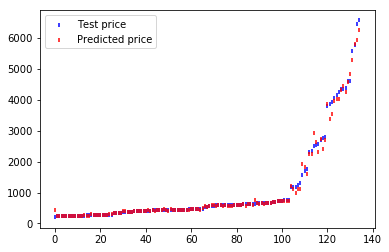

In [21]:
plt.show()

In [22]:
print "Model initiated - GBT "

from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel

model1 = GradientBoostedTrees.trainRegressor(trainingData,categoricalFeaturesInfo={}, numIterations=3)
predictions1 = model1.predict(testData.map(lambda x: x.features))
labelsAndPredictions1 = testData.map(lambda lp: lp.label).zip(predictions1)
labelsAndPredictions1.cache()
acc1 = labelsAndPredictions1.map(lambda x: ((x[0]/x[1])*100)).reduce(add)
print ("Closeness Index : %.2f%%"  %(acc1/labelsAndPredictions1.count()))

from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.mllib.linalg import DenseVector

metrics = RegressionMetrics(labelsAndPredictions1)
print("MSE = %s" % metrics.meanSquaredError)
print("RMSE = %s" % metrics.rootMeanSquaredError)
print("R-squared = %s" % metrics.r2)
print("MAE = %s" % metrics.meanAbsoluteError)


Model initiated - GBT 
Closeness Index : 103.28%
MSE = 34711.1365518
RMSE = 186.309249775
R-squared = 0.981781442194
MAE = 121.290591248


In [23]:
predict1=labelsAndPredictions1.sortByKey().map(lambda a:a[1]).collect()
label1=labelsAndPredictions1.sortByKey().map(lambda a:a[0]).collect()
x=range(int(labelsAndPredictions.count()))

fig = plt.figure()
ax2 = fig.add_subplot(111)
ax2.scatter(x, label1, s=10, c='b', marker="|", label='Test price')
ax2.scatter(x,predict1, s=10, c='r', marker="|", label='Predicted price')
plt.legend(loc='upper left');

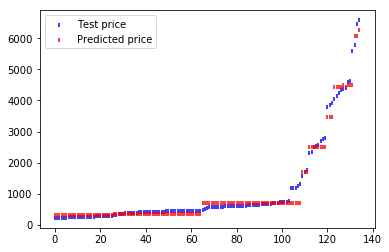

In [24]:
plt.show()